In [1]:
import cv2
import os
from joblib import Parallel, delayed
from tqdm import tqdm
import re
import numpy as np
import scipy
import skimage
import ants
import matplotlib.pyplot as plt

def get_ksize(sigma):
    # opencv calculates ksize from sigma as
    # sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    # then ksize from sigma is
    # ksize = ((sigma - 0.8)/0.15) + 2.0

    return int(((sigma - 0.8)/0.15) + 2.0)

def get_gaussian_blur(img, ksize=0, sigma=5):
    # if ksize == 0, then compute ksize from sigma
    if ksize == 0:
        ksize = get_ksize(sigma)

    # Gaussian 2D-kernel can be seperable into 2-orthogonal vectors
    # then compute full kernel by taking outer product or simply mul(V, V.T)
    sep_k = cv2.getGaussianKernel(ksize, sigma)

    # if ksize >= 11, then convolution is computed by applying fourier transform
    return cv2.filter2D(img, -1, np.outer(sep_k, sep_k))

def ssr(img, sigma):
    # Single-scale retinex of an image
    # SSR(x, y) = log(I(x, y)) - log(I(x, y)*F(x, y))
    # F = surrounding function, here Gaussian

    return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)

def msr(img, sigma_scales=[15, 80, 250]):
    # Multi-scale retinex of an image
    # MSR(x,y) = sum(weight[i]*SSR(x,y, scale[i])), i = {1..n} scales

    msr = np.zeros(img.shape)
    # for each sigma scale compute SSR
    for sigma in sigma_scales:
        msr += ssr(img, sigma)

    # divide MSR by weights of each scale
    # here we use equal weights
    msr = msr / len(sigma_scales)

    # computed MSR could be in range [-k, +l], k and l could be any real value
    # so normalize the MSR image values in range [0, 255]
    msr = cv2.normalize(msr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)

    return msr

def color_balance(img, low_per, high_per):
    '''Contrast stretch img by histogram equilization with black and white cap'''

    tot_pix = img.shape[1] * img.shape[0]
    # no.of pixels to black-out and white-out
    low_count = tot_pix * low_per / 100
    high_count = tot_pix * (100 - high_per) / 100

    # channels of image
    ch_list = []
    if len(img.shape) == 2:
        ch_list = [img]
    else:
        ch_list = cv2.split(img)

    cs_img = []
    # for each channel, apply contrast-stretch
    for i in range(len(ch_list)):
        ch = ch_list[i]
        # cummulative histogram sum of channel
        cum_hist_sum = np.cumsum(cv2.calcHist([ch], [0], None, [256], (0, 256)))

        # find indices for blacking and whiting out pixels
        li, hi = np.searchsorted(cum_hist_sum, (low_count, high_count))
        if (li == hi):
            cs_img.append(ch)
            continue
        # lut with min-max normalization for [0-255] bins
        lut = np.array([0 if i < li
                        else (255 if i > hi else round((i - li) / (hi - li) * 255))
                        for i in np.arange(0, 256)], dtype = 'uint8')
        # constrast-stretch channel
        cs_ch = cv2.LUT(ch, lut)
        cs_img.append(cs_ch)

    if len(cs_img) == 1:
        return np.squeeze(cs_img)
    elif len(cs_img) > 1:
        return cv2.merge(cs_img)
    return None

def msrcr(img, sigma_scales=[15, 80, 250], alpha=125, beta=46, G=192, b=-30, low_per=1, high_per=3):
    # Multi-scale retinex with Color Restoration
    # MSRCR(x,y) = G * [MSR(x,y)*CRF(x,y) - b], G=gain and b=offset
    # CRF(x,y) = beta*[log(alpha*I(x,y) - log(I'(x,y))]
    # I'(x,y) = sum(Ic(x,y)), c={0...k-1}, k=no.of channels

    img = img.astype(np.float64) + 1.0
    # Multi-scale retinex and don't normalize the output
    msr_img = msr(img, sigma_scales)
    # Color-restoration function
    crf = beta * (np.log10(alpha * img) - np.log10(np.sum(img, axis=2, keepdims=True)))
    # MSRCR
    msrcr_ = G * (msr_img*crf - b)
    # normalize MSRCR
    msrcr_ = cv2.normalize(msrcr_, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3) # type: ignore
    # color balance the final MSRCR to flat the histogram distribution with tails on both sides
    msrcr_ = color_balance(msrcr_, low_per, high_per)

    return msrcr_



In [2]:
class BFIWSlide:
    def __init__(self, slide_path, key=None, is_ref=False):
        self.slide_path = slide_path
        self.key = key
        self.img = cv2.imread(slide_path)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.msr_img = None
        self.msr_img_gray = None
        self.mask = None
        self.is_ref = is_ref
        self.apply_msrcr()
        self.get_mask()
        self.apply_mask(self.mask)

    def apply_msrcr(self):
        self.msr_img = msrcr(self.img)
        self.msr_img_gray = cv2.cvtColor(self.msr_img, cv2.COLOR_RGB2GRAY)

    def apply_mask(self, mask):
        self.temp_img = (np.ones_like(self.img) * 255).astype(np.uint8)
        self.temp_img[mask == 1] = self.img[mask == 1]
        self.img = self.temp_img
        self.temp_img = (np.ones_like(self.img) * 255).astype(np.uint8)
        self.temp_img[mask == 1] = self.msr_img[mask == 1]
        self.msr_img = self.temp_img

    def get_mask(self):
        if self.msr_img_gray is None:
            self.apply_msrcr()
        sample_ants = ants.from_numpy(self.msr_img_gray)
        self.mask = sample_ants.get_mask(cleanup=4).numpy().astype(np.uint8) # type: ignore
        # return self.mask
    
    def apply_crop(self, crop):
        self.img = self.img[crop[0]:crop[1], crop[2]:crop[3]]
        self.msr_img = self.msr_img[crop[0]:crop[1], crop[2]:crop[3]]
        self.mask = self.mask[crop[0]:crop[1], crop[2]:crop[3]]
    
    def get_block_contours(self):
        contours, _ = cv2.findContours(self.mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        self.block_contour=contours[0]
        self.block_bbox =  cv2.boundingRect(self.block_contour)
        self.block_crop = (self.block_bbox[1], self.block_bbox[1]+self.block_bbox[3], self.block_bbox[0], self.block_bbox[0]+self.block_bbox[2])

    def apply_block_crop(self):
        self.apply_crop(self.block_crop)

def make_slide(slide_path, key=None, is_ref=False):
    slide = BFIWSlide(slide_path, key, is_ref)
    return {key: slide}



In [3]:
class BFIWReg:
    def __init__(self, src_dir, dest_dir, ref_idx) -> None:
        self.src_dir = src_dir
        self.dest_dir = dest_dir
        imgs = os.listdir(self.src_dir)
        regex = re.compile(r".*-SE_(\d+)_original.jpg")
        imgs = sorted(imgs, key=lambda x: int(regex.match(x).group(1)))
        imgs_ordered = {}
        for img in imgs:
            section_num = int(regex.match(img).group(1))
            section_id = str(section_num)
            section_id_digits = len(section_id)
            if section_id_digits <4:
                section_id = '0'*(4-section_id_digits) + str(section_num)
            imgs_ordered[section_id] = os.path.join(self.src_dir, img)
        self.imgs = imgs_ordered
        if ref_idx not in self.imgs:
            raise ValueError("Reference index not found in the image list")
        # self.ref_slide = BFIWSlide(self.imgs[ref_idx], key=ref_idx, is_ref=True)
        self.slides_ = Parallel(n_jobs=32)(delayed(make_slide)(img, key) for key, img in tqdm(self.imgs.items()))
        self.slides = {}
        for slide in self.slides_:
            self.slides.update(slide)
        self.ref_slide = self.slides[ref_idx]
        self.ref_slide.is_ref = True
        print("Applying Reference Slide Mask to all slides")
        for key, slide in tqdm(self.slides.items()):
            if key == ref_idx:
                continue
            slide.apply_mask(self.ref_slide.mask)
        self.ref_slide.get_block_contours()
        self.ref_crop = self.ref_slide.block_crop
        print("Applying Reference Slide Crop to all slides")
        for key, slide in tqdm(self.slides.items()):
            slide.apply_crop(self.ref_crop) 
        print("Applying Own Slide Block Crop to all slides")
        for key, slide in tqdm(self.slides.items()):
            slide.get_block_contours()
            slide.apply_block_crop()
    
    def save_output(self):
        print("Saving `img` and `msr_img` of all slides")
        if not os.path.exists(self.dest_dir):
            os.makedirs(self.dest_dir, exist_ok=True)
        if not os.path.exists(os.path.join(self.dest_dir, "msrcr")):
            os.makedirs(os.path.join(self.dest_dir, "msrcr"), exist_ok=True)
        if not os.path.exists(os.path.join(self.dest_dir, "original")):
            os.makedirs(os.path.join(self.dest_dir, "original"), exist_ok=True)
        for key, slide in tqdm(self.slides.items()):
            cv2.imwrite(os.path.join(self.dest_dir, f"original/{key}.jpg"), cv2.cvtColor(slide.img, cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(self.dest_dir, f"msrcr/{key}_msrcr.jpg"), cv2.cvtColor(slide.msr_img, cv2.COLOR_RGB2BGR))

# reg = BFIWReg('/storage/valis_reg/test_block', '/storage/valis_reg/test_block_out', '1606')
# reg.save_output()

In [6]:
reg = BFIWReg('/storage/valis_reg/train_block', '/storage/valis_reg/train_block_out', '1606')
# reg.save_output()

100%|██████████| 34/34 [00:00<00:00, 83.06it/s]


Applying Reference Slide Mask to all slides


100%|██████████| 34/34 [00:11<00:00,  2.86it/s]


Applying Reference Slide Crop to all slides


100%|██████████| 34/34 [00:00<00:00, 111324.23it/s]


Applying Own Slide Block Crop to all slides


100%|██████████| 34/34 [00:00<00:00, 114.51it/s]


In [7]:
reg.save_output()

Saving `img` and `msr_img` of all slides


100%|██████████| 34/34 [00:01<00:00, 26.65it/s]


In [8]:
def transform_img(image):
    image = cv2.GaussianBlur(image, (9, 9), 0.8)
    green_thresh = skimage.filters.threshold_otsu(image[:,:,1])
    img_g = image[:,:,1] <= green_thresh
    img_g = scipy.ndimage.binary_fill_holes(img_g)
    img_g = scipy.ndimage.binary_closing(img_g, iterations=20)
    # Dilation
    kernel = np.ones((3,3),np.uint8)
    img_g = cv2.dilate(img_g.astype(np.uint8), kernel, iterations = 15)

    contours, _ = cv2.findContours(img_g.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contour = contours[0]
    contour_mask = np.zeros_like(img_g)
    contour_mask = cv2.fillPoly(contour_mask.astype(np.uint8), [contour], 1)
    foreground = cv2.bitwise_and(image, image, mask=contour_mask)
    background = cv2.bitwise_and(image, image, mask=1-contour_mask)
    result = {
        "fg" : foreground,
        "bg" : background,
        "mask" : contour_mask,
        "img_g": img_g
    }
    return result

In [9]:
train_images = []
label_masks  = []
slide_masks = []
for k, slide in tqdm(reg.slides.items()):
    if k== '1606' or k =='1588':
        continue
    tissue_trans = transform_img(slide.msr_img)
    train_images.append(slide.msr_img)
    label_masks.append(tissue_trans['mask'])
    slide_masks.append(slide.mask)

100%|██████████| 34/34 [00:05<00:00,  5.95it/s]


#### Create Training Data from existing Slides

In [44]:
# Pixelwise Classifier Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange
from sklearn.metrics import balanced_accuracy_score, f1_score


X = np.array([])
y = np.array([])
for i in trange(len(train_images)):
    image = train_images[i]
    mask = label_masks[i]
    slide_mask = slide_masks[i]
    act_mask = mask+slide_mask
    bg_mask = (act_mask==1).astype(np.uint8)
    tissue_mask = (act_mask==2).astype(np.uint8)
    img_center = np.array([image.shape[0]//2, image.shape[1]//2])
    # bg_mask = bg_mask - mask
    tissue_coords = np.argwhere(tissue_mask)
    # tissue_coords = tissue_coords/(np.linalg.norm(tissue_coords- img_center, axis=1).reshape(-1, 1)+1e-5)
    tissue_coords = tissue_coords-img_center
    bg_coords = np.argwhere(bg_mask)
    # bg_coords = bg_coords/(np.linalg.norm(bg_coords- img_center, axis=1).reshape(-1, 1)+1e-5)
    bg_coords = bg_coords-img_center
    tX_ = np.c_[image[mask==1], tissue_coords]
    bgX_ = np.c_[image[bg_mask==1], bg_coords][::4]
    ty_ = np.ones(tissue_coords.shape[0])
    by_ = np.zeros(bg_coords.shape[0])[::4]
    X_ = np.concatenate([tX_, bgX_], axis=0)
    y_ = np.concatenate([ty_, by_], axis=0)
    X = np.concatenate([X, X_], axis=0) if X.size else X_
    y = np.concatenate([y, y_], axis=0) if y.size else y_

100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


### Conversion to CuPy for faster Training

In [45]:
import cupy as cp

X = X.astype(np.float32)
y = y.astype(np.float32)

X = cp.array(X)
y = cp.array(y)

In [46]:
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.model_selection import train_test_split as cu_train_test_split

X_train, X_test, y_train, y_test = cu_train_test_split(X, y, test_size=0.1, shuffle=True,stratify=y)
X_test_, X_val, y_test_, y_val = cu_train_test_split(X_test, y_test, test_size=0.3, shuffle=True,stratify=y_test)

In [47]:
model = cuRF(max_depth = 30, n_estimators = 150, n_streams=8, n_bins=256, max_batch_size=32768)

model.fit(X_train, y_train)

In [40]:
model.score(X_val, y_val)

0.9925150871276855

In [41]:
from cuml.metrics import accuracy_score as cu_accuracy

y_pred = model.predict(X_val)
acc = cu_accuracy(y_val, y_pred)
print("Validation Accuracy: ",acc)

y_pred = model.predict(X_test_)
acc = cu_accuracy(y_test_, y_pred)
print("Test Accuracy: ",acc)



Validation Accuracy:  0.9925150871276855
Test Accuracy:  0.9924948811531067


In [14]:
clf = RandomForestClassifier(n_estimators=150, n_jobs=-1, bootstrap=True, warm_start=True, oob_score=False)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True,stratify=y)
X_test_, X_val, y_test_, y_val = train_test_split(X_test, y_test, test_size=0.3, shuffle=True,stratify=y_test)


In [16]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, n_jobs=-1, warm_start=True)

In [ ]:
print(f"Accuracy: {balanced_accuracy_score(y_test_, y_pred)}")

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test_.get(),y_pred.get()))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    729705
         1.0       0.99      1.00      0.99   1772312

    accuracy                           0.99   2502017
   macro avg       0.99      0.99      0.99   2502017
weighted avg       0.99      0.99      0.99   2502017



In [19]:
import treelite.sklearn

rf_model = treelite.sklearn.import_model(clf)

In [21]:
rf_model.serialize("rf_model.tl")

In [23]:
rf_model.dump_as_json(pretty_print=True)

In [23]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models.resnet import ResNet101_Weights, ResNet18_Weights

class PixelWiseClassifierWithBackbone(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(PixelWiseClassifierWithBackbone, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),  # Adjust in_channels based on backbone
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.conv_layers.cuda()
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
        )
        self.upsample.cuda()
        # Final 1x1 convolution for classification
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1, device='cuda')
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.backbone(x)
        x = self.conv_layers(x)
        # print(x.shape)
        x = self.upsample(x)
        # print(x.shape)
        x = self.classifier(x)
        x = self.sigmoid(x)
        return x

# Example usage
model = PixelWiseClassifierWithBackbone(num_classes=1)  # Adjust num_classes as needed
# Define transformations (adjust as needed)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create Training Dataset


In [11]:
class SlideDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        return image, label

train_dataset = SlideDataset(train_images, label_masks, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [31]:
wandb.finish()

bce_loss,██████████▂▁▂▂▁▂▁▁▁▁
dice_loss,█▁▅▁▅▅▅▆▁▁▁▅▁▁▆▁▇▁▁▃
focal_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃██▇
jaccard_loss,█▁▅▁▅▅▅▆▁▁▁▅▁▁▆▁▇▁▁▃
bce_loss,0.0081
dice_loss,0.99766
focal_loss,0.1736
jaccard_loss,0.99883


In [65]:
import wandb
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="PixelClassification",

    # track hyperparameters and run metadata
    config={
    "learning_rate":0.001,
    "architecture": "CNN",
    "dataset": "train_dataset",
    "epochs": 10,
    }
)

In [13]:
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss, FocalLoss


In [24]:
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss, FocalLoss
def train_model(model, train_loader, num_epochs=10,):
    model.train()
    criterion = nn.BCELoss()
    dice = DiceLoss(mode='binary')
    jaccard = JaccardLoss(mode='binary')
    focal = FocalLoss(mode='binary')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.squeeze(1)
            outputs = transforms.Resize(images[0].shape[1:])(outputs)
            loss = criterion(outputs.unsqueeze(0), labels)
            dice_loss = dice(outputs.unsqueeze(0), labels)
            jaccard_loss = jaccard(outputs.unsqueeze(0), labels)
            focal_loss = focal(outputs.unsqueeze(0), labels)
            loss = criterion(outputs.unsqueeze(0), labels)
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print(f"Epoch: {epoch}, Loss: {loss.item()}")
                
        wandb.log({
            "dice_loss": dice_loss.item(),
            "jaccard_loss": jaccard_loss.item(),
            "focal_loss": focal_loss.item(),
            "bce_loss": loss.item()
            })


train_model(model, train_loader, num_epochs=10)

Epoch: 0, Loss: 0.677221417427063
Epoch: 0, Loss: 0.012502966448664665
Epoch: 0, Loss: 0.08447713404893875
Epoch: 0, Loss: 0.055609047412872314
Epoch: 1, Loss: 0.0834987461566925
Epoch: 1, Loss: 0.1388983279466629
Epoch: 1, Loss: 0.14266450703144073
Epoch: 1, Loss: 0.0951019749045372
Epoch: 2, Loss: 0.07106077671051025
Epoch: 2, Loss: 0.13818633556365967
Epoch: 2, Loss: 0.11204668879508972
Epoch: 2, Loss: 0.09304032474756241
Epoch: 3, Loss: 0.14275449514389038
Epoch: 3, Loss: 0.12492752820253372
Epoch: 3, Loss: 0.14033807814121246
Epoch: 3, Loss: 0.09233985841274261
Epoch: 4, Loss: 0.0600423738360405
Epoch: 4, Loss: 0.11728644371032715
Epoch: 4, Loss: 0.1173849031329155
Epoch: 4, Loss: 0.05707762762904167
Epoch: 5, Loss: 0.07104809582233429
Epoch: 5, Loss: 0.11177341639995575
Epoch: 5, Loss: 0.12416783720254898
Epoch: 5, Loss: 0.09223911911249161
Epoch: 6, Loss: 0.07449799031019211
Epoch: 6, Loss: 0.07098931819200516
Epoch: 6, Loss: 0.010639290325343609
Epoch: 6, Loss: 0.01038991287350

torch.float32

In [29]:
# Load an image
image = cv2.imread('train_block_out/msrcr/0507_msrcr.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = transform(image)
image_input = image.unsqueeze(0)  # Add batch dimension
# Forward pass
image_input = image_input.cuda()
with torch.no_grad():  # No need to track gradients during inference
    output = model(image_input)
    threshold = 0.5
    output = (output > threshold).float()
# output = output.cpu().numpy()

tensor(0., device='cuda:0')

In [21]:
import torchvision.transforms.functional as F

# img = F.to_pil_image(image)

In [187]:
image = cv2.imread('train_block_out/msrcr/1426_msrcr.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(1598, 1842, 3)

In [222]:
output.squeeze(0).shape
image_input.shape


torch.Size([1, 3, 1598, 1842])

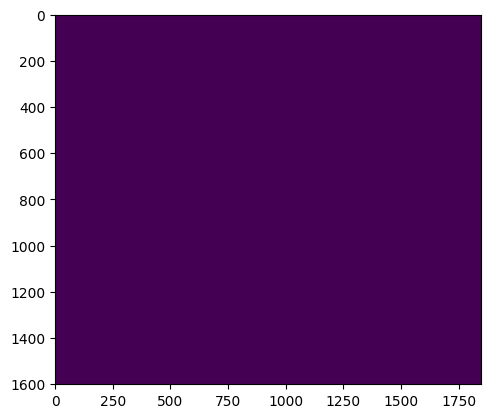

In [205]:
plt.imshow(af)